## **Importing libraries and datasets**

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [6]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [7]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [8]:
print('Min',df_transactions['trans_date'].min())
print('Max',df_transactions['trans_date'].max())

Min 2011-05-16 00:00:00
Max 2015-03-16 00:00:00


## **Data Preparation**

In [9]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [89]:
#Time between purchase (days)
df_trans2 = df_transactions.copy()
df_trans2.sort_values(['customer_id','trans_date'],inplace=True)
df_trans2['previous_trans_date'] = df_trans2.groupby(['customer_id'])['trans_date'].shift(1)
df_trans2= df_trans2[~(df_trans2['previous_trans_date'].isna())]
df_trans2['days_between_trans'] = df_trans2['trans_date']-df_trans2['previous_trans_date'] 
df_trans2['days_between_trans'].astype('timedelta64[D]')
df_trans2['days_between_trans']=df_trans2['days_between_trans'] / np.timedelta64(1, 'D')
df_tbp = df_trans2.groupby(['customer_id']).agg({'days_between_trans': lambda x: x.mean()}).reset_index()
df_tbp.rename(columns={'days_between_trans':'days_between_trans'},inplace=True)

df_trans3 = df_transactions.copy()
df_trans3.sort_values(['customer_id','trans_date'],inplace=True)
df_trans3['rank']=df_trans3.groupby('customer_id')['trans_date'].rank(method='dense',ascending=False)
df_trans3 = df_trans3[df_trans3['rank']==1]
df_trans3.rename(columns={'tran_amount':'last_purchase'},inplace=True)
df_trans3 = df_trans3[['customer_id','last_purchase']]
df_trans3 = df_trans3.groupby('customer_id').sum().reset_index()

In [90]:
df_trans3.head(10)

,customer_id,last_purchase
0,CS1112,39
1,CS1113,176
2,CS1114,79
3,CS1115,55
4,CS1116,90
5,CS1117,66
6,CS1118,60
7,CS1119,59
8,CS1120,53
9,CS1121,37


In [94]:
#Trans Quarter
df_transq = df_transactions[df_transactions['trans_date']>=dt.datetime(2013,3,17)]
df_transq['Quarter'] =  df_transq['trans_date'].dt.quarter
df_transqt = df_transq.groupby(['customer_id','Quarter']).agg({'tran_amount':'sum','recent':'count'}).reset_index()
df_transqt.rename(columns={'recent':'Freq'},inplace=True)

df_transqt=df_transqt.pivot(index='customer_id',columns='Quarter',values=['Freq'])
df_transqt.index.name = 'customer_id'
df_transqt.columns = ['%s%s' % (a, '_Q%s' % b if b else '') for a, b in df_transqt.columns]
df_transqt.reset_index(inplace=True)

df_transqt.drop(['Freq_Q1'],axis=1,inplace=True)
df_transqt.fillna(0,inplace=True)

In [97]:
## create data set with RFM variables
df_transactions = df_transactions[df_transactions['trans_date']>=dt.datetime(2013,3,17)]
df_rfm1 = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})  # Monetary Value
df_rfm1.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency_2y', 
                         'tran_amount': 'monetary_value_2y'}, inplace=True)
df_rfm1.reset_index(inplace=True)

df_rfm2 = df_transactions.groupby('customer_id').agg({'tran_amount':lambda x: x.mean()}).reset_index()
df_rfm2.rename(columns={'tran_amount':'median_purchase_2y'}, inplace=True)

df_rfm3 = df_transactions.groupby('customer_id').agg({'tran_amount':lambda x: x.std()}).reset_index()
df_rfm3.rename(columns={'tran_amount':'std_amount_2y'}, inplace=True)

df_rfm3.fillna(0,inplace=True)

In [98]:
## create data set with RFM variables 1yr
df_transaction_1y = df_transactions.copy()
df_transaction_1y = df_transaction_1y[df_transaction_1y['trans_date']>=dt.datetime(2014,3,17)]
df_rfm_1y = df_transaction_1y.groupby('customer_id').agg({'customer_id': lambda x: len(x)})  
df_rfm_1y.rename(columns={'customer_id': 'frequency_1y'}, inplace=True)
df_rfm_1y.reset_index(inplace=True)

In [99]:
#Merge data
df_rfm = pd.merge(df_rfm1,df_rfm2)
df_rfm = pd.merge(df_rfm,df_rfm3)
df_rfm = pd.merge(df_rfm,df_rfm_1y)
df_rfm = pd.merge(df_rfm,df_transqt)
df_rfm = pd.merge(df_rfm,df_trans3)
df_rfm.head(10)

,customer_id,recency,frequency_2y,monetary_value_2y,median_purchase_2y,std_amount_2y,frequency_1y,Freq_Q2,Freq_Q3,Freq_Q4,last_purchase
0,CS1112,62.0,6,358,59.666667,20.235283,4,1.0,2.0,2.0,39
1,CS1113,36.0,11,775,70.454545,23.888757,6,4.0,3.0,0.0,176
2,CS1114,33.0,11,804,73.090909,24.010225,5,1.0,3.0,4.0,79
3,CS1115,12.0,11,831,75.545455,15.577956,3,4.0,1.0,2.0,55
4,CS1116,204.0,5,333,66.600000,25.234896,4,2.0,1.0,0.0,90
5,CS1117,258.0,11,776,70.545455,15.750325,3,4.0,3.0,0.0,66
6,CS1118,3.0,11,757,68.818182,21.418768,6,2.0,0.0,4.0,60
7,CS1119,12.0,9,698,77.555556,20.464061,5,1.0,3.0,2.0,59
8,CS1120,11.0,14,915,65.357143,20.742402,7,3.0,2.0,3.0,53
9,CS1121,42.0,10,506,50.600000,17.308957,5,1.0,0.0,2.0,37


Exception ignored in: <function Booster.__del__ at 0x7fb2759dfdd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
Exception ignored in: <function Booster.__del__ at 0x7fb2759dfdd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


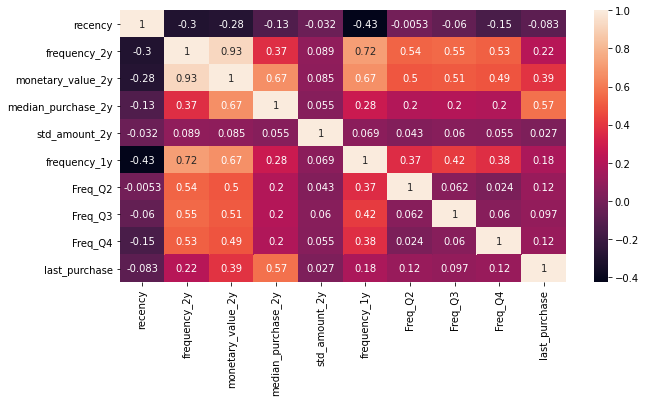

In [100]:
plt.figure(figsize=(10,5))
sns.heatmap(df_rfm.corr(),annot=True)
plt.show()

## **Calculating response rate**

In [20]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


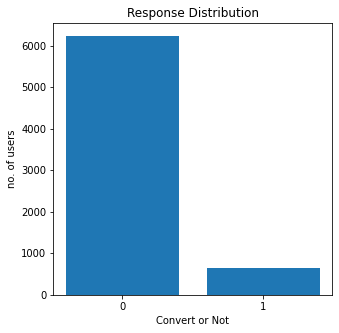

In [101]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

# data is imbalanced

In [102]:
## merging two data sets

df_modeling1 = pd.merge(df_response,df_rfm)
df_modeling = pd.merge(df_modeling1,df_tbp)
df_modeling['Freq_Q2'] = df_modeling['Freq_Q2']/df_modeling['frequency_2y']
df_modeling['Freq_Q3'] = df_modeling['Freq_Q3']/df_modeling['frequency_2y']
df_modeling['Freq_Q4'] = df_modeling['Freq_Q4']/df_modeling['frequency_2y']
df_modeling['last_purchase'] = df_modeling['last_purchase']/df_modeling['monetary_value_2y']
df_modeling.head()

,customer_id,response,recency,frequency_2y,monetary_value_2y,median_purchase_2y,std_amount_2y,frequency_1y,Freq_Q2,Freq_Q3,Freq_Q4,last_purchase,days_between_trans
0,CS1112,0,62.0,6,358,59.666667,20.235283,4,0.166667,0.333333,0.333333,0.108939,112.40
1,CS1113,0,36.0,11,775,70.454545,23.888757,6,0.363636,0.272727,0.000000,0.227097,66.00
2,CS1114,1,33.0,11,804,73.090909,24.010225,5,0.090909,0.272727,0.363636,0.098259,62.60
3,CS1115,1,12.0,11,831,75.545455,15.577956,3,0.363636,0.090909,0.181818,0.066185,71.50
4,CS1116,1,204.0,5,333,66.600000,25.234896,4,0.400000,0.200000,0.000000,0.270270,49.75


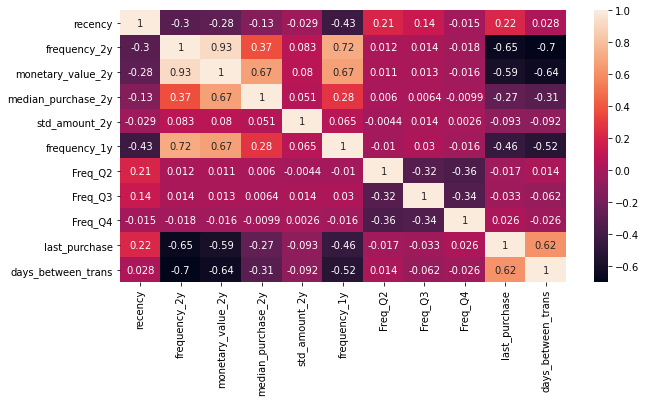

In [103]:
plt.figure(figsize=(10,5))
sns.heatmap(df_modeling.drop('response',axis=1).corr(),annot=True)

In [104]:
df_modeling.shape

(6777, 13)

## **Creating train and test dataset**

In [105]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4743, 11)
Number transactions y_train dataset:  (4743,)
Number transactions X_test dataset:  (2034, 11)
Number transactions y_test dataset:  (2034,)


Exception ignored in: <function Booster.__del__ at 0x7fb2759dfdd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


Text(0.5, 1.0, 'Imbalanced Data')

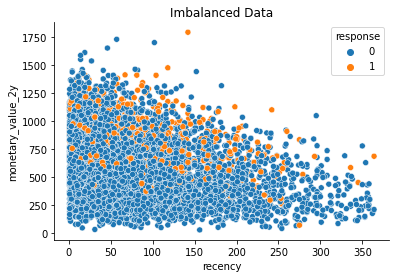

In [107]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("Imbalanced Data")

# **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

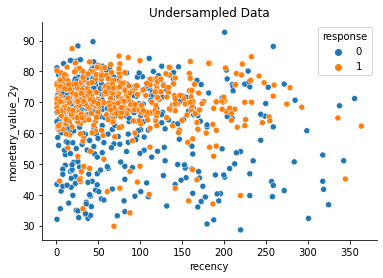

In [108]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency','median_purchase_2y','frequency_2y','monetary_value_2y','std_amount_2y','frequency_1y', 'Freq_Q2', 'Freq_Q3', 'Freq_Q4','last_purchase','days_between_trans', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("Undersampled Data")

# **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

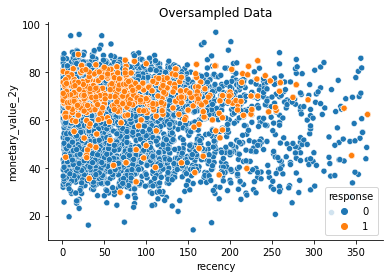

In [109]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency','median_purchase_2y','frequency_2y', 'monetary_value_2y','std_amount_2y','frequency_1y', 'Freq_Q2', 'Freq_Q3', 'Freq_Q4','last_purchase','days_between_trans', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("Oversampled Data")

# **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

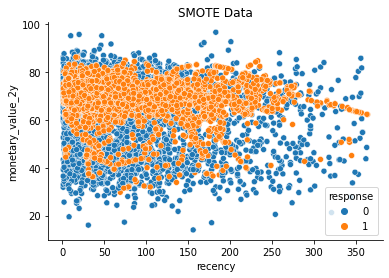

In [110]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency','median_purchase_2y','frequency_2y', 'monetary_value_2y','std_amount_2y','frequency_1y','Freq_Q2', 'Freq_Q3', 'Freq_Q4','last_purchase','days_between_trans', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("SMOTE Data")

# **Logistic Regression Model**

In [111]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       445
           1       0.70      0.78      0.74       445

    accuracy                           0.72       890
   macro avg       0.72      0.72      0.72       890
weighted avg       0.72      0.72      0.72       890

test set
              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1834
           1       0.20      0.78      0.32       200

    accuracy                           0.68      2034
   macro avg       0.58      0.72      0.55      2034
weighted avg       0.89      0.68      0.74      2034



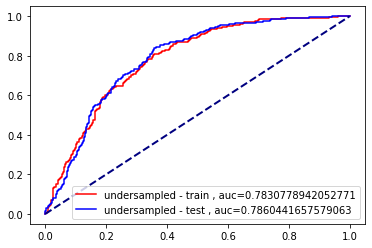

In [112]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [113]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 3.11127825e-03  1.59212469e-01  5.03420780e-04  1.56848637e-02
  -1.68948475e-02 -3.18370976e-02 -4.49879466e-02  4.85580037e-01
   2.79827335e-01 -8.71303751e-01 -2.65380033e-02]] [-1.26755851]


In [114]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      4298
           1       0.70      0.78      0.73      4298

    accuracy                           0.72      8596
   macro avg       0.72      0.72      0.72      8596
weighted avg       0.72      0.72      0.72      8596

test set
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1834
           1       0.20      0.83      0.33       200

    accuracy                           0.66      2034
   macro avg       0.59      0.74      0.55      2034
weighted avg       0.90      0.66      0.73      2034



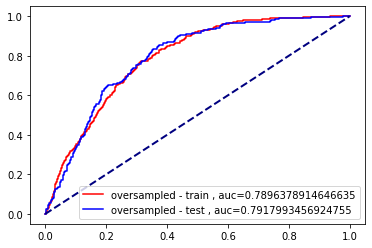

In [115]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [116]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.00567382  0.39393659 -0.00342274  0.06457137 -0.00817111  0.03272739
   0.08244531  0.2448451  -0.02312053 -2.9993098  -0.02258209]] [-1.26755851]


In [117]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      4298
           1       0.71      0.78      0.74      4298

    accuracy                           0.73      8596
   macro avg       0.73      0.73      0.73      8596
weighted avg       0.73      0.73      0.73      8596

test set
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      1834
           1       0.20      0.81      0.32       200

    accuracy                           0.67      2034
   macro avg       0.59      0.73      0.55      2034
weighted avg       0.89      0.67      0.73      2034



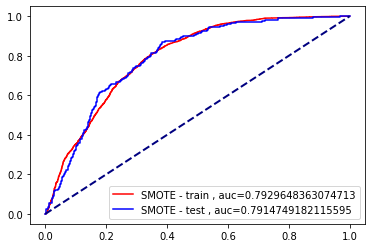

In [118]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [119]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 5.36561171e-03  2.99679906e-01 -2.04119165e-03  4.87301408e-02
  -1.77276038e-02  1.71988746e-02  3.47292695e-01  5.14735379e-01
  -8.26926939e-02 -2.45414738e+00 -2.61739654e-02]] [-1.26755851]
